In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import yaml, matplotlib, random, pickle, time
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import morlet2, cwt
from sklearn.mixture import GaussianMixture

from helper import _rotational, angle_calc

# Start Analysis

In [3]:
with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [57]:
bp_list, scale_list, angles_list, power_list = [], [], [], []
for path in tqdm(glob(f"{config['input_data_path']}/**/*.h5")):
    # Import
    store = pd.HDFStore(path, mode='a')
    df = store['df_with_missing']
    x_data = df.xs('x', level="coords", axis=1).to_numpy()
    y_data = df.xs('y', level="coords", axis=1).to_numpy()
    store.close()
    
    # Center
    x_center = x_data[:,config['bp_center']]
    y_center = y_data[:,config['bp_center']]
    x_data -= x_center[:,np.newaxis]
    y_data -= y_center[:,np.newaxis]
        
    # Format
    DLC_data = np.concatenate((
        np.expand_dims(x_data, axis=-1), 
        np.expand_dims(y_data, axis=-1)), axis=-1)

    # Scale
    x_d = DLC_data[:,config['bp_scale'][0],0] - DLC_data[:,config['bp_scale'][1],0]
    y_d = DLC_data[:,config['bp_scale'][0],1] - DLC_data[:,config['bp_scale'][1],1]
    dist = np.sqrt(x_d**2+y_d**2)
    norm = np.median(dist)
    scale_list.append(norm)
    DLC_data /= norm

    # Rotate
    ROT_data, body_angle = _rotational(data=DLC_data, axis_bp=config['bp_rotate'])
    bp_list.append(ROT_data)

    # Angles
    angles = angle_calc(ROT_data, config['angles'])
    angles -= np.mean(angles, axis=0)
    angles_list.append(angles)
    
    if path.find("groom") != -1:
        break

# Combine Bodypoints and Angles Data
tot_bp = np.concatenate(bp_list, axis=0)
tot_angles = np.concatenate(angles_list, axis=0)  

for angles in angles_list:
    # Normalize Angles
    angles -= np.mean(tot_angles, axis=0)
    # Morlet Wavelet
    num_fr, num_ang = angles.shape
    power = np.zeros((num_ang, config['f_bin'], num_fr))
    max_freq, min_freq = config['fps']/2, 1 # Nyquist Frequency
    freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
        (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1))
    widths = config['w']*config['fps'] / (2*freq*np.pi)
    # Normalization Factor
    s = (config['w'] + np.sqrt(2+config['w']**2))/(4*np.pi*freq)
    C = np.pi**(-0.25)*np.exp(0.25*(config['w']-np.sqrt(config['w']**2+2))**2)/np.sqrt(2*s)
    for i in range(num_ang):
        cwtm = cwt(angles[:,i], morlet2, widths, dtype=None, w=config['w'])
        power[i] = (np.abs(cwtm)**2)
#         power[i] = np.abs(cwtm/np.expand_dims(np.sqrt(s),1))
        power[i] = (np.abs(cwtm/np.expand_dims(np.sqrt(s),1)))/np.expand_dims(C, axis=(0,2))
    power_list.append(power)

tot_pwr = np.concatenate(power_list, axis=2)

In [47]:
power.shape

(2, 20, 2680)

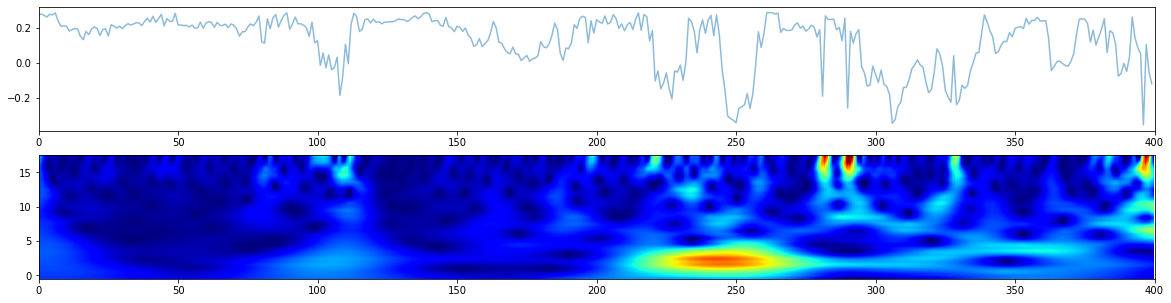

In [45]:
start_fr, stop_fr = 0, 400
ang_idx = 0

fig, ax = plt.subplots(2, figsize=(20,5))
ax[0].plot(np.arange(start_fr, stop_fr), angles[start_fr:stop_fr, ang_idx], alpha=0.5)
ax[1].imshow(power[ang_idx,:,start_fr:stop_fr], cmap="jet", origin="lower", interpolation="sinc", filterrad=0.1) #

ax[0].set_xlim(start_fr,stop_fr)
ax[1].set_xlim(start_fr,stop_fr)
ax[1].set_aspect('auto')

plt.show()

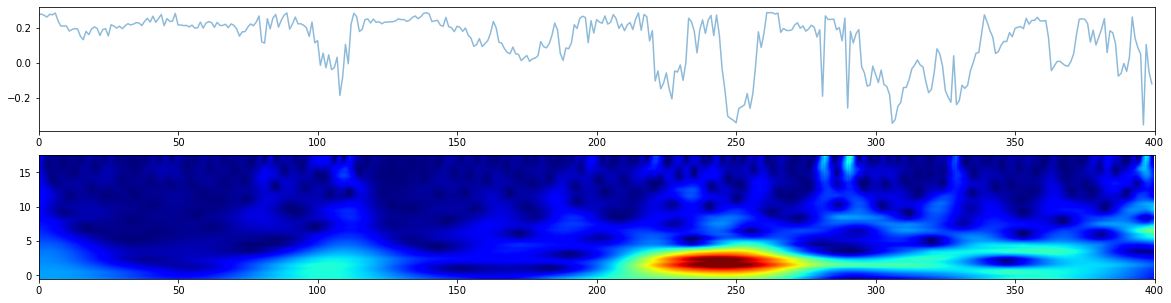

In [48]:
start_fr, stop_fr = 0, 400
ang_idx = 0

fig, ax = plt.subplots(2, figsize=(20,5))
ax[0].plot(np.arange(start_fr, stop_fr), angles[start_fr:stop_fr, ang_idx], alpha=0.5)
ax[1].imshow(power[ang_idx,:,start_fr:stop_fr], cmap="jet", origin="lower", interpolation="sinc", filterrad=0.1) #

ax[0].set_xlim(start_fr,stop_fr)
ax[1].set_xlim(start_fr,stop_fr)
ax[1].set_aspect('auto')

plt.show()

# Check Power

In [82]:
fps = 50
time = np.arange(0,500)/fps
sig = np.sin(2*np.pi*13*time) + np.sin(2*np.pi*2*time)

In [106]:
# Compute Param
max_freq, min_freq = config['fps']/2, 1 # Nyquist Frequency
freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
    (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1))
widths = config['w']*config['fps'] / (2*freq*np.pi)

# Normalization Factor
s = (config['w'] + np.sqrt(2+config['w']**2))/(4*np.pi*freq)
C = np.pi**(-0.25)*np.exp(0.25*(config['w']-np.sqrt(config['w']**2+2))**2)/np.sqrt(2*s)

cwtm = cwt(sig, morlet2, widths, dtype=None, w=config['w'])
power = (np.abs(cwtm/np.expand_dims(np.sqrt(s),1)))/np.expand_dims(C, axis=(1))

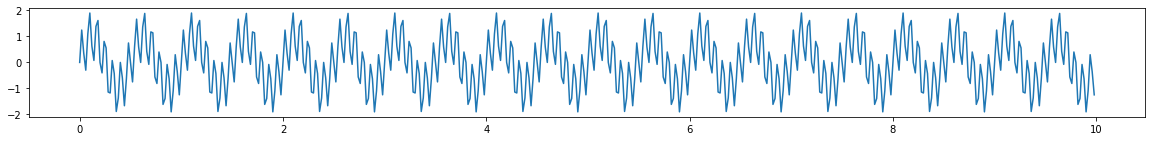

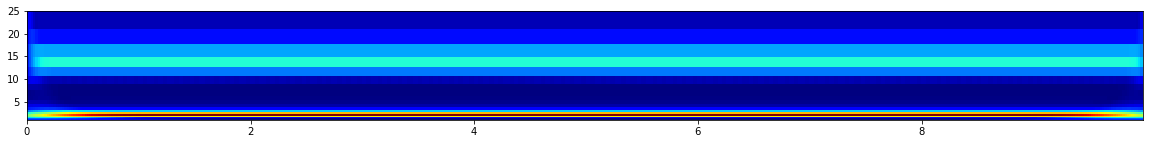

In [107]:
fig, ax = plt.subplots(figsize=(20,2))
ax.plot(time, sig)
plt.show()
fig, ax = plt.subplots(figsize=(20,2))
ax.pcolormesh(time, freq, power[:,:], cmap="jet")#, origin="lower", interpolation="sinc", filterrad=0.1
plt.show()

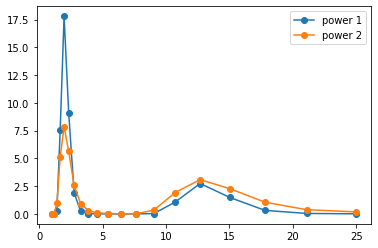

In [109]:
plt.plot(freq, power1[:,200], marker="o", label="power 1")
plt.plot(freq, power[:,200], marker="o", label="power 2")
plt.legend()
plt.show()

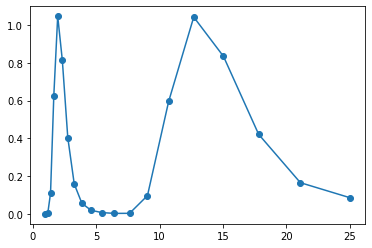

In [105]:
plt.plot(freq, power3[:,200]*C/(2*np.pi), marker="o")



In [99]:
C

array([0.59533547, 0.64796218, 0.705241  , 0.76758317, 0.8354363 ,
       0.90928753, 0.98966709, 1.07715208, 1.1723706 , 1.27600629,
       1.3888032 , 1.51157119, 1.64519166, 1.79062397, 1.94891227,
       2.121193  , 2.30870307, 2.51278873, 2.73491523, 2.97667736])

# Angles Analysis

In [114]:
# *** DEFINE ***
fps=50
results_path = "results/test_angles"

# Collect Data
pickle_in = open(f"{results_path}/files_ref.pickle","rb")
files_ref = pickle.load(pickle_in)
bodypoints = np.load(f"{results_path}/bodypoints.npy")
scales = np.load(f"{results_path}/scales.npy")
angles = np.load(f"{results_path}/angles.npy")
freq = np.load(f"{results_path}/freq.npy")
power = np.load(f"{results_path}/power.npy")
embed = np.load(f"{results_path}/embeddings.npy")

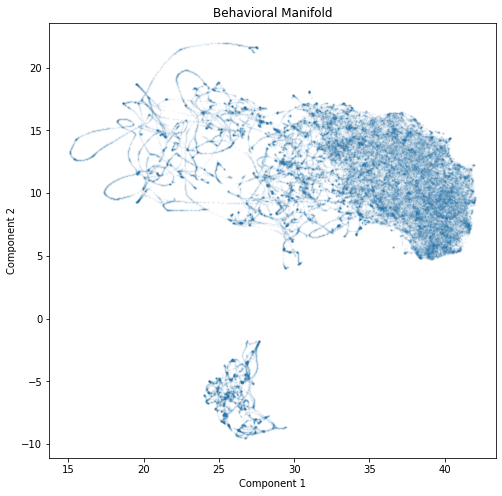

In [115]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(embed[:,0], embed[:,1], alpha=0.05, s=1)  
ax.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold")
plt.show()